In [1]:
# including the project directory to the notebook level
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
from tqdm import tqdm
import parse
import warnings

In [2]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    import tensorflow as tf
    config = tf.ConfigProto(log_device_placement=False)
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    
    from keras import backend as K
    from nn_source import models as mp
from dataprocess import dataprocessor as dp
from dataprocess import plotutils as pu

Using TensorFlow backend.


In [3]:
# read the pickled file for ahu data
ahudata = dp.readfile('../data/processed/ahu1energy.pkl')

# return pickled df
ahu = ahudata.return_df(processmethods=['file2df'])

# read the pickled file for ghi data
ghidata = dp.readfile('../data/processed/ghi.pkl')

# return pickled df
ghi = ghidata.return_df(processmethods=['file2df'])

In [4]:
# selecting only required columns and rearranging them
ahu = ahu[[
    'AHU_1 outdoorAirTemp', 'WeatherDataProfile humidity',
    'AHU_1 supplyAirTemp', 'HW_BTU_METER currentKbtuDeltaReading',
    'CHW_BTU_METER currentKbtuDeltaReading'
]]

# renaming columns
ahu.columns = ['oat', 'orh', 'sat', 'hwe', 'cwe']

# Total energy is sum of heating and coling
ahu['totale'] = ahu['hwe'] + ahu['cwe']
# dropping heating and cooling energy columns
ahu = ahu.drop(columns=['hwe', 'cwe'])

In [5]:
# merging ahu and ghi data
df = dp.merge_df_columns([ahu, ghi])

# rearranging columns
df = df[['oat', 'orh', 'sat', 'Ghi', 'totale']]

In [6]:
df.head()

,oat,orh,sat,Ghi,totale
2018-07-12 13:55:00,89.554909,76.0,75.443275,872.0,35.590466
2018-07-12 14:00:00,89.863190,76.0,75.443275,866.0,33.027813
2018-07-12 14:05:00,89.863190,76.0,75.443275,859.0,31.769627
2018-07-12 14:10:00,90.484146,69.0,75.443275,848.0,34.195641
2018-07-12 14:15:00,90.826981,69.0,75.443275,836.0,31.082222


In [ ]:
df['HourSine'] = np.sin(2 * np.pi * df.index.hour / 24.0)
df['HourCos'] = np.cos(2 * np.pi * df.index.hour / 24.0)
df['WeekSine'] = np.sin(2 * np.pi * df.index.week / 52.0)
df['WeekCos'] = np.cos(2 * np.pi * df.index.week / 52.0)
df['DayofWeekSine'] = np.sin(2 * np.pi * df.index.dayofweek / 7.0)
df['DayofWeekCos'] = np.cos(2 * np.pi * df.index.dayofweek / 7.0)

In [ ]:
df = df[[
    'oat', 'orh', 'sat', 'Ghi', 'HourSine', 'HourCos', 'WeekSine', 'WeekCos',
    'DayofWeekSine', 'DayofWeekCos', 'totale'
]]

In [ ]:
df.head()

In [7]:
# Creating a list of 7 day dataframes for training
dflist = dp.df2dflist(df, subsequence=True, period=1, days=7, hours=0)

In [8]:
len(dflist)

22

In [9]:
# create list of training, testing arrays
weeklist = []
for weekdata in dflist:
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        weekdata,
        predictorcols=['oat', 'orh', 'sat', 'Ghi'],
        outputcols=['totale'],
        scaling=True,
        feature_range=(0,1),
        reshaping=True,
        lag=-1
    )
    weeklist.append({
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
    })

In [10]:
for i in weeklist[0].keys():
    print(weeklist[0][i].shape)

(1511, 1, 4)
(1511, 1, 1)
(504, 1, 4)
(504, 1, 1)


In [11]:
!rm -rf ../results/*

In [12]:
# create the results directory
try:
    os.mkdir('../results/lstmtrain/')
except FileExistsError:
    files = os.listdir('../results/lstmtrain/')
    for f in files:
        os.remove('../results/lstmtrain/' + f)
        
os.mkdir('../results/lstmtrain/loginfo')

In [13]:
try:
    del model
except NameError:
    pass

K.clear_session()

In [14]:
config = {
    'weeklist': weeklist,
    'lstm_hidden_units': 8,
    'lstm_no_layers': 1,
    'dense_hidden_units': 32,
    'dense_no_layers': 4
}

modeldesigndone = False
initial_epoch = 0
for weekno, weekdata in enumerate(tqdm(config['weeklist'])):

    X_train = weekdata['X_train']
    y_train = weekdata['y_train']
    X_test = weekdata['X_test']
    y_test = weekdata['y_test']

    if not modeldesigndone:
        #Instantiate learner model
        model = mp.lstm_model('../results/lstmtrain/',
                              inputdim=X_train.shape[-1],
                              outputdim=y_train.shape[-1],
                              period=1)

        # Desing model architecture
        model.design_model(lstmhiddenlayers=[config['lstm_hidden_units']] * config['lstm_no_layers'],
                           densehiddenlayers=[config['dense_hidden_units']] * config['dense_no_layers'],
                           dropoutlist=[[], []],
                           batchnormalizelist=[[], []])

        # creating early stopping and learning reate changing callbacks
        model.model_callbacks()

        modeldesigndone = True

    # train the model
    history = model.train_model(X_train, y_train, X_test, y_test, epochs=1000, initial_epoch = initial_epoch)
    initial_epoch += len(history.history['loss'])

    # evaluate the model for metrics at this stage
    # see inside results folder to look at t
    # train and test plots as well as logged errors inside the text file
    preds_train, preds_test = model.evaluate_model(X_train,
                                                   y_train,
                                                   X_test,
                                                   y_test,
                                                   y_scaler,
                                                   scaling=True,
                                                   saveplot=True,
                                                   Week=weekno)

  0%|          | 0/22 [00:00<?, ?it/s]




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1511 samples, validate on 504 samples



Epoch 1/1000
1511/1511 [==============================] - 1s 981us/step - loss: 0.4950 - val_loss: 0.3646
Epoch 2/1000
1511/1511 [==============================] - 1s 412us/step - loss: 0.3096 - val_loss: 0.2492
Epoch 3/1000
1511/1511 [==============================] - 1s 411us/step - loss: 0.2140 - val_loss: 0.1697
Epoch 4/1000
1511/1511 [==============================] - 1s 415us/step - loss: 0.1471 - val_loss: 0.1150
Epoch 5/1000
1511/1511 [==============================] - 1s 413us/step - loss: 0.1020 - val_loss: 0.0791
Epoch 6/1000
1511/1511 [==============================] - 1s 408us/step - loss: 0.0720 - val_loss: 0.0548
Epoch 7/1000
1511/1511 [==============================] - 1s 411us/step - loss: 0.0518 - val_loss: 0.0382
Epoch 8/1000
1511/1511 [==============================] - 1s 413us/step - loss: 0.0379 - val_loss: 0.0270
Epoch

  5%|▍         | 1/22 [00:27<09:33, 27.30s/it]

Train on 1511 samples, validate on 504 samples
Epoch 23/1000
1511/1511 [==============================] - 1s 397us/step - loss: 0.0264 - val_loss: 0.0255
Epoch 24/1000
1511/1511 [==============================] - 1s 404us/step - loss: 0.0250 - val_loss: 0.0241
Epoch 25/1000
1511/1511 [==============================] - 1s 412us/step - loss: 0.0238 - val_loss: 0.0228
Epoch 26/1000
1511/1511 [==============================] - 1s 415us/step - loss: 0.0227 - val_loss: 0.0217
Epoch 27/1000
1511/1511 [==============================] - 1s 410us/step - loss: 0.0217 - val_loss: 0.0207
Epoch 28/1000
1511/1511 [==============================] - 1s 405us/step - loss: 0.0209 - val_loss: 0.0198
Epoch 29/1000
1511/1511 [==============================] - 1s 411us/step - loss: 0.0201 - val_loss: 0.0190
Epoch 30/1000
1511/1511 [==============================] - 1s 404us/step - loss: 0.0194 - val_loss: 0.0183
Epoch 31/1000
1511/1511 [==============================] - 1s 410us/step - loss: 0.0188 - val_los

  9%|▉         | 2/22 [01:17<11:20, 34.04s/it]

Train on 1511 samples, validate on 504 samples
Epoch 81/1000
1511/1511 [==============================] - 1s 396us/step - loss: 0.0197 - val_loss: 0.0501
Epoch 82/1000
1511/1511 [==============================] - 1s 409us/step - loss: 0.0197 - val_loss: 0.0501
Epoch 83/1000
1511/1511 [==============================] - 1s 412us/step - loss: 0.0197 - val_loss: 0.0501
Epoch 84/1000
1511/1511 [==============================] - 1s 408us/step - loss: 0.0197 - val_loss: 0.0501
Epoch 85/1000
1511/1511 [==============================] - 1s 408us/step - loss: 0.0197 - val_loss: 0.0501
Epoch 86/1000
1511/1511 [==============================] - 1s 410us/step - loss: 0.0197 - val_loss: 0.0501


 14%|█▎        | 3/22 [01:23<08:11, 25.87s/it]

Train on 1511 samples, validate on 504 samples
Epoch 87/1000
1511/1511 [==============================] - 1s 391us/step - loss: 0.0271 - val_loss: 0.0343
Epoch 88/1000
1511/1511 [==============================] - 1s 411us/step - loss: 0.0271 - val_loss: 0.0343
Epoch 89/1000
1511/1511 [==============================] - 1s 417us/step - loss: 0.0271 - val_loss: 0.0343
Epoch 90/1000
1511/1511 [==============================] - 1s 404us/step - loss: 0.0271 - val_loss: 0.0343
Epoch 91/1000
1511/1511 [==============================] - 1s 419us/step - loss: 0.0271 - val_loss: 0.0343
Epoch 92/1000
1511/1511 [==============================] - 1s 411us/step - loss: 0.0271 - val_loss: 0.0343


 18%|█▊        | 4/22 [01:30<06:02, 20.13s/it]

Train on 1511 samples, validate on 504 samples
Epoch 93/1000
1511/1511 [==============================] - 1s 397us/step - loss: 0.0260 - val_loss: 0.0114
Epoch 94/1000
1511/1511 [==============================] - 1s 406us/step - loss: 0.0260 - val_loss: 0.0114
Epoch 95/1000
1511/1511 [==============================] - 1s 408us/step - loss: 0.0260 - val_loss: 0.0114
Epoch 96/1000
1511/1511 [==============================] - 1s 412us/step - loss: 0.0260 - val_loss: 0.0114
Epoch 97/1000
1511/1511 [==============================] - 1s 407us/step - loss: 0.0260 - val_loss: 0.0114
Epoch 98/1000
1511/1511 [==============================] - 1s 407us/step - loss: 0.0260 - val_loss: 0.0114


 23%|██▎       | 5/22 [01:37<04:34, 16.12s/it]

Train on 1511 samples, validate on 504 samples
Epoch 99/1000
1511/1511 [==============================] - 1s 393us/step - loss: 0.0252 - val_loss: 0.0356
Epoch 100/1000
1511/1511 [==============================] - 1s 408us/step - loss: 0.0252 - val_loss: 0.0356
Epoch 101/1000
1511/1511 [==============================] - 1s 411us/step - loss: 0.0252 - val_loss: 0.0356
Epoch 102/1000
1511/1511 [==============================] - 1s 414us/step - loss: 0.0252 - val_loss: 0.0356
Epoch 103/1000
1511/1511 [==============================] - 1s 415us/step - loss: 0.0252 - val_loss: 0.0356
Epoch 104/1000
1511/1511 [==============================] - 1s 410us/step - loss: 0.0252 - val_loss: 0.0356


 27%|██▋       | 6/22 [01:44<03:33, 13.32s/it]

Train on 1511 samples, validate on 504 samples
Epoch 105/1000
1511/1511 [==============================] - 1s 403us/step - loss: 0.0316 - val_loss: 0.0236
Epoch 106/1000
1511/1511 [==============================] - 1s 409us/step - loss: 0.0316 - val_loss: 0.0236
Epoch 107/1000
1511/1511 [==============================] - 1s 410us/step - loss: 0.0316 - val_loss: 0.0236
Epoch 108/1000
1511/1511 [==============================] - 1s 413us/step - loss: 0.0316 - val_loss: 0.0236
Epoch 109/1000
1511/1511 [==============================] - 1s 416us/step - loss: 0.0316 - val_loss: 0.0236
Epoch 110/1000
1511/1511 [==============================] - 1s 408us/step - loss: 0.0316 - val_loss: 0.0236


 32%|███▏      | 7/22 [01:50<02:50, 11.37s/it]

Train on 1511 samples, validate on 504 samples
Epoch 111/1000
1511/1511 [==============================] - 1s 395us/step - loss: 0.0266 - val_loss: 0.0059
Epoch 112/1000
1511/1511 [==============================] - 1s 411us/step - loss: 0.0266 - val_loss: 0.0059
Epoch 113/1000
1511/1511 [==============================] - 1s 410us/step - loss: 0.0266 - val_loss: 0.0059
Epoch 114/1000
1511/1511 [==============================] - 1s 412us/step - loss: 0.0266 - val_loss: 0.0059
Epoch 115/1000
1511/1511 [==============================] - 1s 411us/step - loss: 0.0266 - val_loss: 0.0059
Epoch 116/1000
1511/1511 [==============================] - 1s 415us/step - loss: 0.0266 - val_loss: 0.0059


 36%|███▋      | 8/22 [01:58<02:21, 10.07s/it]

Train on 1511 samples, validate on 504 samples
Epoch 117/1000
1511/1511 [==============================] - 1s 393us/step - loss: 0.0342 - val_loss: 0.0734
Epoch 118/1000
1511/1511 [==============================] - 1s 414us/step - loss: 0.0342 - val_loss: 0.0734
Epoch 119/1000
1511/1511 [==============================] - 1s 413us/step - loss: 0.0342 - val_loss: 0.0734
Epoch 120/1000
1511/1511 [==============================] - 1s 413us/step - loss: 0.0342 - val_loss: 0.0734
Epoch 121/1000
1511/1511 [==============================] - 1s 412us/step - loss: 0.0342 - val_loss: 0.0734
Epoch 122/1000
1511/1511 [==============================] - 1s 408us/step - loss: 0.0342 - val_loss: 0.0734


 41%|████      | 9/22 [02:04<01:58,  9.09s/it]

Train on 1511 samples, validate on 504 samples
Epoch 123/1000
1511/1511 [==============================] - 1s 394us/step - loss: 0.0194 - val_loss: 0.0090
Epoch 124/1000
1511/1511 [==============================] - 1s 410us/step - loss: 0.0194 - val_loss: 0.0090
Epoch 125/1000
1511/1511 [==============================] - 1s 414us/step - loss: 0.0194 - val_loss: 0.0090
Epoch 126/1000
1511/1511 [==============================] - 1s 408us/step - loss: 0.0194 - val_loss: 0.0090
Epoch 127/1000
1511/1511 [==============================] - 1s 414us/step - loss: 0.0194 - val_loss: 0.0090
Epoch 128/1000
1511/1511 [==============================] - 1s 413us/step - loss: 0.0194 - val_loss: 0.0090


 45%|████▌     | 10/22 [02:11<01:40,  8.41s/it]

Train on 1511 samples, validate on 504 samples
Epoch 129/1000
1511/1511 [==============================] - 1s 398us/step - loss: 0.0333 - val_loss: 0.0316
Epoch 130/1000
1511/1511 [==============================] - 1s 412us/step - loss: 0.0333 - val_loss: 0.0316
Epoch 131/1000
1511/1511 [==============================] - 1s 415us/step - loss: 0.0333 - val_loss: 0.0316
Epoch 132/1000
1511/1511 [==============================] - 1s 415us/step - loss: 0.0333 - val_loss: 0.0316
Epoch 133/1000
1511/1511 [==============================] - 1s 412us/step - loss: 0.0333 - val_loss: 0.0316
Epoch 134/1000
1511/1511 [==============================] - 1s 413us/step - loss: 0.0333 - val_loss: 0.0316


 50%|█████     | 11/22 [02:18<01:27,  7.92s/it]

Train on 1511 samples, validate on 504 samples
Epoch 135/1000
1511/1511 [==============================] - 1s 393us/step - loss: 0.0216 - val_loss: 0.0165
Epoch 136/1000
1511/1511 [==============================] - 1s 406us/step - loss: 0.0216 - val_loss: 0.0165
Epoch 137/1000
1511/1511 [==============================] - 1s 412us/step - loss: 0.0216 - val_loss: 0.0165
Epoch 138/1000
1511/1511 [==============================] - 1s 405us/step - loss: 0.0216 - val_loss: 0.0165
Epoch 139/1000
1511/1511 [==============================] - 1s 410us/step - loss: 0.0216 - val_loss: 0.0165
Epoch 140/1000
1511/1511 [==============================] - 1s 410us/step - loss: 0.0216 - val_loss: 0.0165


 55%|█████▍    | 12/22 [02:25<01:15,  7.57s/it]

Train on 1511 samples, validate on 504 samples
Epoch 141/1000
1511/1511 [==============================] - 1s 395us/step - loss: 0.0147 - val_loss: 0.0168
Epoch 142/1000
1511/1511 [==============================] - 1s 409us/step - loss: 0.0147 - val_loss: 0.0168
Epoch 143/1000
1511/1511 [==============================] - 1s 411us/step - loss: 0.0147 - val_loss: 0.0168
Epoch 144/1000
1511/1511 [==============================] - 1s 408us/step - loss: 0.0147 - val_loss: 0.0168
Epoch 145/1000
1511/1511 [==============================] - 1s 410us/step - loss: 0.0147 - val_loss: 0.0168
Epoch 146/1000
1511/1511 [==============================] - 1s 413us/step - loss: 0.0147 - val_loss: 0.0168


 59%|█████▉    | 13/22 [02:31<01:06,  7.35s/it]

Train on 1511 samples, validate on 504 samples
Epoch 147/1000
1511/1511 [==============================] - 1s 391us/step - loss: 0.0160 - val_loss: 0.0586
Epoch 148/1000
1511/1511 [==============================] - 1s 412us/step - loss: 0.0160 - val_loss: 0.0586
Epoch 149/1000
1511/1511 [==============================] - 1s 415us/step - loss: 0.0160 - val_loss: 0.0586
Epoch 150/1000
1511/1511 [==============================] - 1s 408us/step - loss: 0.0160 - val_loss: 0.0586
Epoch 151/1000
1511/1511 [==============================] - 1s 412us/step - loss: 0.0160 - val_loss: 0.0586
Epoch 152/1000
1511/1511 [==============================] - 1s 411us/step - loss: 0.0160 - val_loss: 0.0586


 64%|██████▎   | 14/22 [02:38<00:57,  7.17s/it]

Train on 1511 samples, validate on 504 samples
Epoch 153/1000
1511/1511 [==============================] - 1s 400us/step - loss: 0.0155 - val_loss: 0.0204
Epoch 154/1000
1511/1511 [==============================] - 1s 414us/step - loss: 0.0155 - val_loss: 0.0204
Epoch 155/1000
1511/1511 [==============================] - 1s 410us/step - loss: 0.0155 - val_loss: 0.0204
Epoch 156/1000
1511/1511 [==============================] - 1s 403us/step - loss: 0.0155 - val_loss: 0.0204
Epoch 157/1000
1511/1511 [==============================] - 1s 407us/step - loss: 0.0155 - val_loss: 0.0204
Epoch 158/1000
1511/1511 [==============================] - 1s 412us/step - loss: 0.0155 - val_loss: 0.0204


 68%|██████▊   | 15/22 [02:45<00:49,  7.05s/it]

Train on 1511 samples, validate on 504 samples
Epoch 159/1000
1511/1511 [==============================] - 1s 394us/step - loss: 0.0300 - val_loss: 0.0229
Epoch 160/1000
1511/1511 [==============================] - 1s 415us/step - loss: 0.0300 - val_loss: 0.0229
Epoch 161/1000
1511/1511 [==============================] - 1s 412us/step - loss: 0.0300 - val_loss: 0.0229
Epoch 162/1000
1511/1511 [==============================] - 1s 412us/step - loss: 0.0300 - val_loss: 0.0229
Epoch 163/1000
1511/1511 [==============================] - 1s 415us/step - loss: 0.0300 - val_loss: 0.0229
Epoch 164/1000
1511/1511 [==============================] - 1s 417us/step - loss: 0.0300 - val_loss: 0.0229


 73%|███████▎  | 16/22 [02:52<00:41,  6.99s/it]

Train on 1511 samples, validate on 504 samples
Epoch 165/1000
1511/1511 [==============================] - 1s 396us/step - loss: 0.0373 - val_loss: 0.0449
Epoch 166/1000
1511/1511 [==============================] - 1s 413us/step - loss: 0.0373 - val_loss: 0.0449
Epoch 167/1000
1511/1511 [==============================] - 1s 414us/step - loss: 0.0373 - val_loss: 0.0449
Epoch 168/1000
1511/1511 [==============================] - 1s 412us/step - loss: 0.0373 - val_loss: 0.0449
Epoch 169/1000
1511/1511 [==============================] - 1s 412us/step - loss: 0.0373 - val_loss: 0.0449
Epoch 170/1000
1511/1511 [==============================] - 1s 414us/step - loss: 0.0373 - val_loss: 0.0449


 77%|███████▋  | 17/22 [02:59<00:34,  6.94s/it]

Train on 1511 samples, validate on 504 samples
Epoch 171/1000
1511/1511 [==============================] - 1s 400us/step - loss: 0.0552 - val_loss: 0.0711
Epoch 172/1000
1511/1511 [==============================] - 1s 413us/step - loss: 0.0552 - val_loss: 0.0711
Epoch 173/1000
1511/1511 [==============================] - 1s 407us/step - loss: 0.0552 - val_loss: 0.0711
Epoch 174/1000
1511/1511 [==============================] - 1s 407us/step - loss: 0.0552 - val_loss: 0.0711
Epoch 175/1000
1511/1511 [==============================] - 1s 403us/step - loss: 0.0552 - val_loss: 0.0711
Epoch 176/1000
1511/1511 [==============================] - 1s 411us/step - loss: 0.0552 - val_loss: 0.0711


 82%|████████▏ | 18/22 [03:05<00:27,  6.89s/it]

Train on 1511 samples, validate on 504 samples
Epoch 177/1000
1511/1511 [==============================] - 1s 395us/step - loss: 0.0297 - val_loss: 0.0309
Epoch 178/1000
1511/1511 [==============================] - 1s 407us/step - loss: 0.0297 - val_loss: 0.0309
Epoch 179/1000
1511/1511 [==============================] - 1s 412us/step - loss: 0.0297 - val_loss: 0.0309
Epoch 180/1000
1511/1511 [==============================] - 1s 409us/step - loss: 0.0297 - val_loss: 0.0309
Epoch 181/1000
1511/1511 [==============================] - 1s 412us/step - loss: 0.0297 - val_loss: 0.0309
Epoch 182/1000
1511/1511 [==============================] - 1s 405us/step - loss: 0.0297 - val_loss: 0.0309


 86%|████████▋ | 19/22 [03:12<00:20,  6.85s/it]

Train on 1511 samples, validate on 504 samples
Epoch 183/1000
1511/1511 [==============================] - 1s 394us/step - loss: 0.0274 - val_loss: 0.0158
Epoch 184/1000
1511/1511 [==============================] - 1s 411us/step - loss: 0.0274 - val_loss: 0.0158
Epoch 185/1000
1511/1511 [==============================] - 1s 407us/step - loss: 0.0274 - val_loss: 0.0158
Epoch 186/1000
1511/1511 [==============================] - 1s 409us/step - loss: 0.0274 - val_loss: 0.0158
Epoch 187/1000
1511/1511 [==============================] - 1s 411us/step - loss: 0.0274 - val_loss: 0.0158
Epoch 188/1000
1511/1511 [==============================] - 1s 411us/step - loss: 0.0274 - val_loss: 0.0158


 91%|█████████ | 20/22 [03:19<00:13,  6.84s/it]

Train on 1511 samples, validate on 504 samples
Epoch 189/1000
1511/1511 [==============================] - 1s 397us/step - loss: 0.0409 - val_loss: 0.0556
Epoch 190/1000
1511/1511 [==============================] - 1s 411us/step - loss: 0.0409 - val_loss: 0.0556
Epoch 191/1000
1511/1511 [==============================] - 1s 417us/step - loss: 0.0409 - val_loss: 0.0556
Epoch 192/1000
1511/1511 [==============================] - 1s 412us/step - loss: 0.0409 - val_loss: 0.0556
Epoch 193/1000
1511/1511 [==============================] - 1s 411us/step - loss: 0.0409 - val_loss: 0.0556
Epoch 194/1000
1511/1511 [==============================] - 1s 406us/step - loss: 0.0409 - val_loss: 0.0556


 95%|█████████▌| 21/22 [03:26<00:06,  6.90s/it]

Train on 1511 samples, validate on 504 samples
Epoch 195/1000
1511/1511 [==============================] - 1s 397us/step - loss: 0.0576 - val_loss: 0.0376
Epoch 196/1000
1511/1511 [==============================] - 1s 410us/step - loss: 0.0576 - val_loss: 0.0376
Epoch 197/1000
1511/1511 [==============================] - 1s 413us/step - loss: 0.0576 - val_loss: 0.0376
Epoch 198/1000
1511/1511 [==============================] - 1s 411us/step - loss: 0.0576 - val_loss: 0.0376
Epoch 199/1000
1511/1511 [==============================] - 1s 412us/step - loss: 0.0576 - val_loss: 0.0376
Epoch 200/1000
1511/1511 [==============================] - 1s 407us/step - loss: 0.0576 - val_loss: 0.0376


100%|██████████| 22/22 [03:33<00:00,  9.70s/it]


In [3]:
# Open a file
fo = open("../results/lstmtrain/5min Results_File.txt", "r")
print ("Name of the file: ", fo.name)
lines = fo.readlines()

parse_format = 'Week No:{}-Time Step {}: {} RMSE={} |{} CVRMSE={} |{} MAE={}'
stats = {
    'Train':{'rmse': [], 'cvrmse' : [], 'mae' : []},
    'Test':{'rmse': [], 'cvrmse' : [], 'mae' : []}
}
for line in lines:
    p = parse.parse(parse_format,line)
    stats[p[2]]['rmse'].append(float(p[3]))
    stats[p[4]]['cvrmse'].append(float(p[5]))
    stats[p[6]]['mae'].append(float(p[7]))
          
fo.close()

Name of the file:  ../results/lstmtrain/5min Results_File.txt


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


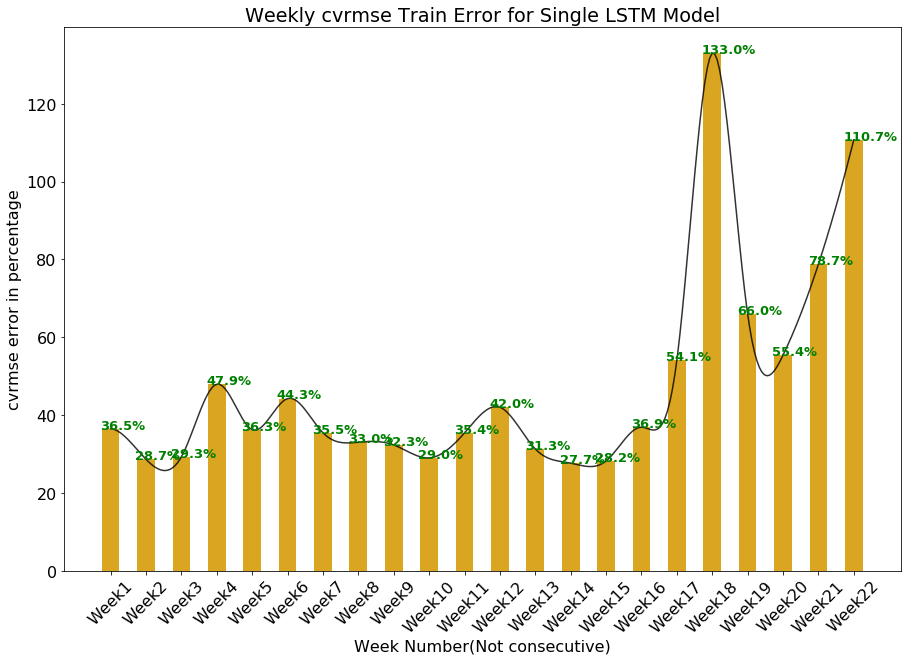

In [4]:
# from dataprocess import plotutils as pu
plot_args = dict(
    bars = stats['Train']['cvrmse'],
    color = 'goldenrod',
    bar_label = 'cvrmse',
    saveloc = '../results/lstmtrain',
    smoothcurve = True,
    bar_annotate = True,
    saveplot = True,
    xlabel = 'Week Number(Not consecutive)',
    ylabel = 'cvrmse error in percentage',
    title = 'Weekly cvrmse Train Error for Single LSTM Model',
    xticktype = 'Week'
)
pu.single_bar_plot(
    **plot_args
)

In [ ]:
model.show_model()

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir '../results/lstmtrain/loginfo/' --port 8200

In [ ]:
dp.dataframeplot(dflist[2], lazy=False, style='-', legend=True)